**Name** : AARUSH MAKARAND VERULKAR <br>
**Github ID** : Aarush-Verulkar-USC <br>
**USC ID** : 1404324513 <br>
**Assignment** : Final Project

# <span style="color:#04a5e5"> **1. Transfer Learning for Image Classification** </span>

**Importing all the necessary packages**

In [4]:
# Standard Libraries
import os
import shutil
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-Learn for Metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, auc, precision_recall_fscore_support, accuracy_score

# Visualization
from tabulate import tabulate

# Warnings Control
import warnings
warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

## **(a) Downloading RealWaste Data Set** 

In [14]:
DATASET_PATH = '/kaggle/input/real-waste/RealWaste'

#### **Checking number of images in each class**

In [15]:
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path '{DATASET_PATH}' does not exist.")
else:
    class_counts = {}
    
    for class_name in os.listdir(DATASET_PATH):
        class_path = os.path.join(DATASET_PATH, class_name)
        if os.path.isdir(class_path):
            img_files = [file for file in os.listdir(class_path) 
                         if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_counts[class_name] = len(img_files)

    table_data = [(class_name, count) for class_name, count in class_counts.items()]
    print(tabulate(table_data, headers=["Class Name", "Number of Images"], tablefmt="fancy_grid"))

╒═══════════════════════╤════════════════════╕
│ Class Name            │   Number of Images │
╞═══════════════════════╪════════════════════╡
│ 6-Paper               │                500 │
├───────────────────────┼────────────────────┤
│ 3-Glass               │                420 │
├───────────────────────┼────────────────────┤
│ 9-Vegetation          │                436 │
├───────────────────────┼────────────────────┤
│ 8-Textile Trash       │                318 │
├───────────────────────┼────────────────────┤
│ 7-Plastic             │                921 │
├───────────────────────┼────────────────────┤
│ 1-Cardboard           │                461 │
├───────────────────────┼────────────────────┤
│ 2-Food Organics       │                411 │
├───────────────────────┼────────────────────┤
│ 4-Metal               │                790 │
├───────────────────────┼────────────────────┤
│ 5-Miscellaneous Trash │                495 │
╘═══════════════════════╧════════════════════╛


## **(b) Data Exploration and Pre-processing**

### **i) Data Splitting & One-Hot Encoding**

In [16]:
BASE_DIR = '/kaggle/working/RealWasteSplit'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

def setup_dirs(dataset_path):
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(VAL_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    split_summary = []

    for class_name in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [img for img in sorted(os.listdir(class_path)) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        total_images = len(images)
        train_size = int(total_images * 0.8)
        val_size = int(train_size * 0.2)

        train_images = images[:train_size - val_size]
        val_images = images[train_size - val_size:train_size]
        test_images = images[train_size:]

        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok=True)
        os.makedirs(os.path.join(VAL_DIR, class_name), exist_ok=True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok=True)

        for img_file in train_images:
            shutil.copy2(os.path.join(class_path, img_file), os.path.join(TRAIN_DIR, class_name, img_file))

        for img in val_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(VAL_DIR, class_name, img))
        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(TEST_DIR, class_name, img))

        split_summary.append([
            class_name, 
            len(train_images), 
            len(val_images), 
            len(test_images),
            total_images
        ])

    print("\nData Split Summary:")
    print(tabulate(split_summary, headers=["Class Name", "Train Images", "Validation", "Test", "Total Images"], tablefmt="fancy_grid"))

In [17]:
setup_dirs(DATASET_PATH)


Data Split Summary:
╒═══════════════════════╤════════════════╤══════════════╤════════╤════════════════╕
│ Class Name            │   Train Images │   Validation │   Test │   Total Images │
╞═══════════════════════╪════════════════╪══════════════╪════════╪════════════════╡
│ 1-Cardboard           │            295 │           73 │     93 │            461 │
├───────────────────────┼────────────────┼──────────────┼────────┼────────────────┤
│ 2-Food Organics       │            263 │           65 │     83 │            411 │
├───────────────────────┼────────────────┼──────────────┼────────┼────────────────┤
│ 3-Glass               │            269 │           67 │     84 │            420 │
├───────────────────────┼────────────────┼──────────────┼────────┼────────────────┤
│ 4-Metal               │            506 │          126 │    158 │            790 │
├───────────────────────┼────────────────┼──────────────┼────────┼────────────────┤
│ 5-Miscellaneous Trash │            317 │           79

### **ii) Zero-padding or resizing the images**

In [8]:
# Checking Image Dimensions for One Image from Each Class
image_dimensions = []

for class_name in sorted(os.listdir(TRAIN_DIR)):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_path = os.path.join(class_path, images[0])  # Only the first image in the class
            img = cv2.imread(img_path)
            if img is not None:
                height, width, channels = img.shape
                image_dimensions.append([class_name, img_path, f"{height} x {width} x {channels}"])
            else:
                image_dimensions.append([class_name, img_path, "Image could not be loaded"])
        else:
            image_dimensions.append([class_name, "No Image Found", "N/A"])

# Displaying the Image Dimensions in a Tabulate Table
print("\nImage Dimensions Summary (One Image Per Class):")
print(tabulate(image_dimensions, headers=["Class Name", "Image Path", "Dimensions"], tablefmt="fancy_grid"))


Image Dimensions Summary (One Image Per Class):
╒═══════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════╤═══════════════╕
│ Class Name            │ Image Path                                                                            │ Dimensions    │
╞═══════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════╪═══════════════╡
│ 1-Cardboard           │ /kaggle/working/RealWasteSplit/train/1-Cardboard/Cardboard_142.jpg                    │ 524 x 524 x 3 │
├───────────────────────┼───────────────────────────────────────────────────────────────────────────────────────┼───────────────┤
│ 2-Food Organics       │ /kaggle/working/RealWasteSplit/train/2-Food Organics/Food Organics_185.jpg            │ 524 x 524 x 3 │
├───────────────────────┼───────────────────────────────────────────────────────────────────────────────────────┼───────────────┤
│ 3-Glass               │ /kaggle/working

**I have taken an image from each class randomly. As we can see, all of them have the same dimensions. Hence, I won't be performing any zero-padding. Although, I have resized the images later in the Transfer Learning process.**

## **(c) Transfer Learning**

### **Part (i), (ii), (iii), (iv)**

---

### **Data Augmentation**

- I applied data augmentation only to the training set to help the model learn generalizable features by exposing it to diverse variations of the images (rotation, flip, zoom, brightness).

- The validation and test sets were kept unchanged because they are meant to simulate unseen data, providing a true measure of the model’s generalization and performance.

- Augmenting validation or test sets would lead to misleading metrics, making the model appear better or worse than it actually is.

In [23]:
augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),          # 10% Rotation
    tf.keras.layers.RandomTranslation(0.1, 0.1),  # 10% Horizontal and Vertical Shift
    tf.keras.layers.RandomZoom(0.2),              # Random Zoom (Up to 20%)
    tf.keras.layers.RandomFlip("horizontal"),     # Horizontal Flip
    tf.keras.layers.RandomContrast(0.2),          # Random Contrast Adjustment
])

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=5,
    image_size=(224, 224),
    shuffle=True,
    seed=24
).map(lambda x, y: (augmentation_layer(x), y))  # Applying Augmentation Directly

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    batch_size=5,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    batch_size=32,  # Consistent Batch Size
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

train_image_count = sum(len(files) for _, _, files in os.walk(TRAIN_DIR))
val_image_count = sum(len(files) for _, _, files in os.walk(VAL_DIR))
test_image_count = sum(len(files) for _, _, files in os.walk(TEST_DIR))


print("\nImage Counts:")
print(f"Training Images: {train_image_count}")
print(f"Testing Images: {test_image_count}")
print(f"Validation Images: {val_image_count}")

Found 3042 files belonging to 9 classes.
Found 756 files belonging to 9 classes.
Found 954 files belonging to 9 classes.

Image Counts:
Training Images: 3042
Testing Images: 954
Validation Images: 756


## How I trained my models:

### 1. Downloading and Preparing Pre-trained Models:
- I began by downloading the pre-trained weights for the models: ResNet50, ResNet101, EfficientNetB0, and VGG16. These weights were obtained from publicly available pre-trained ImageNet models.
- Since I needed to ensure stable and reproducible training, I manually uploaded these pre-trained weights to Kaggle and used them directly from the Kaggle environment.
- By using manually uploaded weights instead of dynamically downloading them during training, I avoided any network instability or version conflicts.

---

### 2. Data Preparation:
- My dataset was divided into three sets:
  - **Training Set (80%)**: Used for model learning.
  - **Validation Set (16%)**: A random 20% subset of the training set, used for monitoring validation loss.
  - **Test Set (20%)**: Used only for final model evaluation.
- I applied data augmentation exclusively on the training set using techniques like random rotation, flipping, zooming, and brightness adjustments. This was done to improve the model's ability to generalize by exposing it to diverse variations of the images.
- Both the validation and test sets were kept unchanged, as they represent unseen data and should reflect the original data distribution.

---

### 3. Model Setup and Architecture Design:
- I used the pre-trained models as feature extractors, ensuring that the base layers of each model were frozen (non-trainable).
- For each model (ResNet50, ResNet101, EfficientNetB0, and VGG16), I built a custom classification head according to the assignment consisting of:
  - A Global Average Pooling layer for feature aggregation.
  - A Dense layer with 256 units, using ReLU activation and L2 regularization (0.0001).
  - A Batch Normalization layer for stable training.
  - A Dropout layer (20%) for regularization, preventing overfitting.
  - An output layer with the softmax activation, providing probabilities for the 9 classes.
- The models were compiled using the Adam optimizer with a learning rate of 0.0001 and categorical cross-entropy loss, suitable for multi-class classification.

---

### 4. Training Process:
- I set up several callbacks for efficient training:
  - **Early Stopping**: Monitored the validation loss with a patience of 5 epochs ensuring that training stopped if no improvement was observed.
  - **Learning Rate Reduction**: Used `ReduceLROnPlateau` to dynamically reduce the learning rate by half if validation loss stopped improving for 5 epochs, ensuring smooth convergence.
  - **Model Checkpointing**: Configured to save only the best model for each architecture based on the lowest validation loss.
- The models were trained on the training set, with the validation set used for monitoring.
- Training was performed for up to 100 epochs, but early stopping ensured that training would automatically stop if the model stopped improving.

---

### 5. Evaluating Model Performance:
- Once trained, I evaluated each model on three sets (training, validation, and test) without any data augmentation.
- I calculated key metrics including:
  - Precision, Recall, and F1-Score for each class.
  - Overall accuracy for each set.
  - AUC (Area Under the Curve) for evaluation of multi-class classification.
---

**I have also consistently followed a 3 step process:**
- Training
- Evaluation Metrics
- Graphs
---

## **ResNet50** - Training & Summary

---

In [30]:
# Using Direct Path for Pre-Downloaded ResNet50 Weights
weights_path = '/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

class_names = sorted(os.listdir('/kaggle/working/RealWasteSplit/train'))
num_classes = len(class_names)
print(f"Number of Classes Detected: {num_classes}")

base_model_resnet50 = ResNet50(
    weights=None,  # We are loading weights manually
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model_resnet50.load_weights(weights_path)

# Freezing Base Model Layers
for layer in base_model_resnet50.layers:
    layer.trainable = False

input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
augmented_input = augmentation_layer(input_layer)  
preprocessed_input = tf.keras.applications.resnet50.preprocess_input(augmented_input)
feature_extractor = base_model_resnet50(preprocessed_input, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor)
x = tf.keras.layers.Dense(256, kernel_regularizer=l2(0.0001))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

resnet50_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

resnet50_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=50
)

checkpoint_callback = ModelCheckpoint(
    "best_resnet50_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

history_resnet50 = resnet50_model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback, reduce_lr_callback, checkpoint_callback],
    verbose=1
)

resnet50_model.summary()

Number of Classes Detected: 9


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_15 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_16 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_17 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[2][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_8 (Stack)           │ (None, 224, 224, 3)    │              0 │ get_item_15[0][0],     │
│                           │                        │                │ get_item_16[0][0],     │
│                           │                        │                │ get_item_17[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 256)            │          1,024 │ dense_8[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_5 (ReLU)            │ (None, 256)            │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256)            │              0 │ re_lu_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 9)              │          2,313 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,115,593 (91.99 MB)

 Trainable params: 527,369 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

Epoch 1/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3441 - loss: 1.9656
Epoch 1: val_loss improved from inf to 1.12285, saving model to best_resnet50_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 67s 91ms/step - accuracy: 0.3446 - loss: 1.9642 - val_accuracy: 0.6574 - val_loss: 1.1229 - learning_rate: 1.0000e-04
Epoch 2/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6605 - loss: 1.0546
Epoch 2: val_loss improved from 1.12285 to 1.03296, saving model to best_resnet50_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 54s 88ms/step - accuracy: 0.6605 - loss: 1.0546 - val_accuracy: 0.6825 - val_loss: 1.0330 - learning_rate: 1.0000e-04
Epoch 3/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6991 - loss: 0.9182
Epoch 3: val_loss improved from 1.03296 to 0.97211, saving model to best_resnet50_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 53s 87ms/step - accuracy: 0.6991 - loss: 0.9182 - val_accuracy: 0.6944 - val_loss: 0.9721 - learning_rate: 1.0000e-04
Epoch 4/100
608/6

In [32]:
best_resnet50_model = tf.keras.models.load_model("best_resnet50_model.keras")

def evaluate_model(model, dataset, set_name="Set"):
    y_true = []
    y_pred = []
    y_pred_prob = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.append(labels)
        y_pred_prob.append(predictions)
        y_pred.append(np.argmax(predictions, axis=1))
    
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)

    y_true_labels = np.argmax(y_true, axis=1)

    accuracy = accuracy_score(y_true_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    except ValueError:
        auc = 0.0  

    return [set_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}", f"{auc:.4f}"]

eval_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

train_results = evaluate_model(best_resnet50_model, eval_train_dataset, "Training Set")
val_results = evaluate_model(best_resnet50_model, val_dataset, "Validation Set")
test_results = evaluate_model(best_resnet50_model, test_dataset, "Test Set")

results_table = [train_results, val_results, test_results]
print("\nFinal Model Performance Summary (ResNet50):")
print(tabulate(results_table, headers=["Set", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"], tablefmt="fancy_grid"))

Found 3042 files belonging to 9 classes.

Final Model Performance Summary (ResNet50):
╒════════════════╤════════════╤═════════════╤══════════╤════════════╤════════╕
│ Set            │   Accuracy │   Precision │   Recall │   F1 Score │    AUC │
╞════════════════╪════════════╪═════════════╪══════════╪════════════╪════════╡
│ Training Set   │     0.834  │      0.839  │   0.834  │     0.8303 │ 0.9856 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Validation Set │     0.7116 │      0.7022 │   0.7116 │     0.6876 │ 0.9565 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Test Set       │     0.7411 │      0.7385 │   0.7411 │     0.7276 │ 0.96   │
╘════════════════╧════════════╧═════════════╧══════════╧════════════╧════════╛


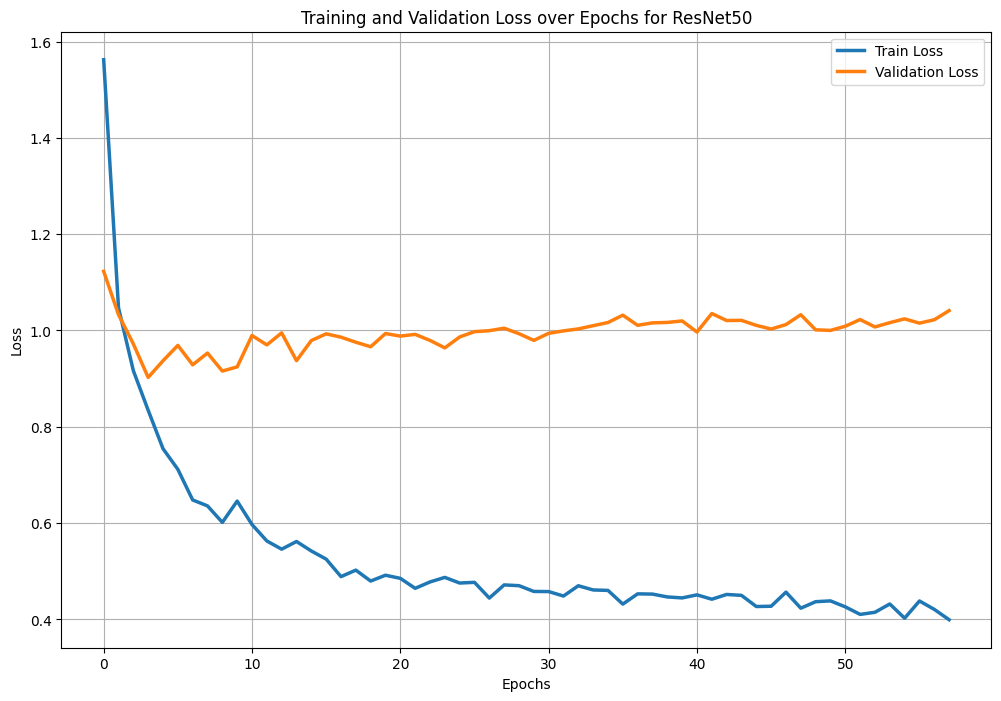

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50.history['loss'], label='Train Loss', linewidth=2.5)
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title("Training and Validation Loss over Epochs for ResNet50")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **ResNet101** - Training & Summary

---

In [33]:
weights_path_resnet101 = '/kaggle/input/resnet101/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5'

class_names = sorted(os.listdir('/kaggle/working/RealWasteSplit/train'))
num_classes = len(class_names)
print(f"Number of Classes Detected: {num_classes}")

base_model_resnet101 = ResNet101(
    weights=None,  # We are loading weights manually
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model_resnet101.load_weights(weights_path_resnet101)

for layer in base_model_resnet101.layers:
    layer.trainable = False

input_layer_101 = tf.keras.layers.Input(shape=(224, 224, 3))
augmented_input_101 = augmentation_layer(input_layer_101)  # Applying Augmentation
preprocessed_input_101 = tf.keras.applications.resnet.preprocess_input(augmented_input_101)
feature_extractor_101 = base_model_resnet101(preprocessed_input_101, training=False)

x_101 = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor_101)
x_101 = tf.keras.layers.Dense(256, kernel_regularizer=l2(0.0001))(x_101)
x_101 = tf.keras.layers.BatchNormalization()(x_101)
x_101 = tf.keras.layers.ReLU()(x_101)
x_101 = tf.keras.layers.Dropout(0.2)(x_101)
output_layer_101 = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x_101)

resnet101_model = tf.keras.models.Model(inputs=input_layer_101, outputs=output_layer_101)

resnet101_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


reduce_lr_callback_101 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

early_stopping_callback_101 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch = 50
)

checkpoint_callback_101 = ModelCheckpoint(
    "best_resnet101_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

train_dataset_101 = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset_101 = val_dataset.prefetch(tf.data.AUTOTUNE)

history_resnet101 = resnet101_model.fit(
    train_dataset_101,
    epochs=100,
    validation_data=val_dataset_101,
    callbacks=[early_stopping_callback_101, reduce_lr_callback_101, checkpoint_callback_101],
    verbose=1
)
resnet101_model.summary()

Number of Classes Detected: 9


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_18 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[3][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_19 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[3][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_20 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[3][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_10 (Stack)          │ (None, 224, 224, 3)    │              0 │ get_item_18[0][0],     │
│                           │                        │                │ get_item_19[0][0],     │
│                           │                        │                │ get_item_20[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet101 (Functional)    │ (None, 7, 7, 2048)     │     42,658,176 │ add_6[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet101[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 256)            │          1,024 │ dense_10[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 256)            │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 256)            │              0 │ re_lu_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 9)              │          2,313 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 43,186,057 (164.74 MB)

 Trainable params: 527,369 (2.01 MB)

 Non-trainable params: 42,658,688 (162.73 MB)

Epoch 1/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3413 - loss: 1.9350
Epoch 1: val_loss improved from inf to 1.08886, saving model to best_resnet101_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 84s 103ms/step - accuracy: 0.3417 - loss: 1.9338 - val_accuracy: 0.6521 - val_loss: 1.0889 - learning_rate: 1.0000e-04
Epoch 2/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6624 - loss: 1.0668
Epoch 2: val_loss improved from 1.08886 to 1.02359, saving model to best_resnet101_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 57s 94ms/step - accuracy: 0.6624 - loss: 1.0667 - val_accuracy: 0.6667 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 3/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6999 - loss: 0.9162
Epoch 3: val_loss improved from 1.02359 to 0.94188, saving model to best_resnet101_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 58s 95ms/step - accuracy: 0.6999 - loss: 0.9161 - val_accuracy: 0.6931 - val_loss: 0.9419 - learning_rate: 1.0000e-04
Epoch 4/100
6

In [34]:
best_resnet101_model = tf.keras.models.load_model("best_resnet101_model.keras")

def evaluate_model(model, dataset, set_name="Set"):
    y_true = []
    y_pred = []
    y_pred_prob = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.append(labels)
        y_pred_prob.append(predictions)
        y_pred.append(np.argmax(predictions, axis=1))
    
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)

    y_true_labels = np.argmax(y_true, axis=1)

    accuracy = accuracy_score(y_true_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    except ValueError:
        auc = 0.0  

    return [set_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}", f"{auc:.4f}"]

eval_train_dataset_101 = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

train_results_101 = evaluate_model(best_resnet101_model, eval_train_dataset_101, "Training Set")
val_results_101 = evaluate_model(best_resnet101_model, val_dataset, "Validation Set")
test_results_101 = evaluate_model(best_resnet101_model, test_dataset, "Test Set")

results_table_101 = [train_results_101, val_results_101, test_results_101]
print("\nFinal Model Performance Summary (ResNet101):")
print(tabulate(results_table_101, headers=["Set", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"], tablefmt="fancy_grid"))

Found 3042 files belonging to 9 classes.

Final Model Performance Summary (ResNet101):
╒════════════════╤════════════╤═════════════╤══════════╤════════════╤════════╕
│ Set            │   Accuracy │   Precision │   Recall │   F1 Score │    AUC │
╞════════════════╪════════════╪═════════════╪══════════╪════════════╪════════╡
│ Training Set   │     0.9211 │      0.9282 │   0.9211 │     0.9216 │ 0.997  │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Validation Set │     0.7447 │      0.7628 │   0.7447 │     0.7412 │ 0.9663 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Test Set       │     0.7526 │      0.7586 │   0.7526 │     0.7434 │ 0.9717 │
╘════════════════╧════════════╧═════════════╧══════════╧════════════╧════════╛


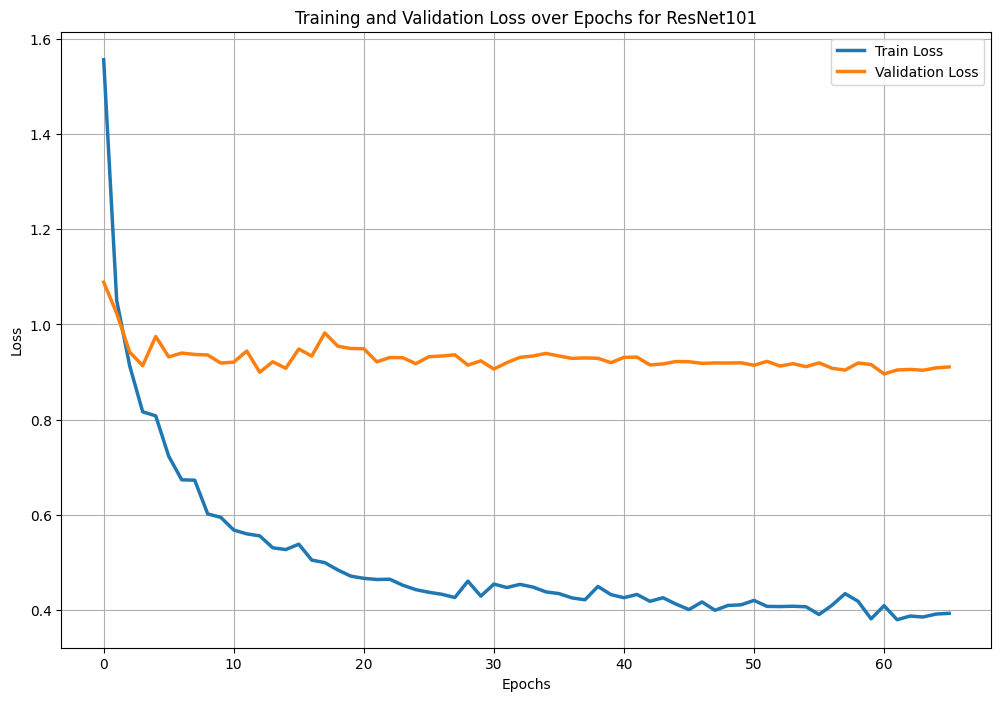

In [60]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet101.history['loss'], label='Train Loss', linewidth=2.5)
plt.plot(history_resnet101.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title("Training and Validation Loss over Epochs for ResNet101")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## **EfficientNetB0** - Training & Summary

---

In [35]:
weights_path_efficientnet = '/kaggle/input/efficientnetb0/efficientnetb0_notop.h5'

class_names = sorted(os.listdir('/kaggle/working/RealWasteSplit/train'))
num_classes = len(class_names)
print(f"Number of Classes Detected: {num_classes}")

base_model_efficientnet = EfficientNetB0(
    weights=None,  
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model_efficientnet.load_weights(weights_path_efficientnet)

for layer in base_model_efficientnet.layers:
    layer.trainable = False

input_layer_effnet = tf.keras.layers.Input(shape=(224, 224, 3))
augmented_input_effnet = augmentation_layer(input_layer_effnet)  # Applying Augmentation
preprocessed_input_effnet = tf.keras.applications.efficientnet.preprocess_input(augmented_input_effnet)
feature_extractor_effnet = base_model_efficientnet(preprocessed_input_effnet, training=False)

x_effnet = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor_effnet)
x_effnet = tf.keras.layers.Dense(256, kernel_regularizer=l2(0.0001))(x_effnet)
x_effnet = tf.keras.layers.BatchNormalization()(x_effnet)
x_effnet = tf.keras.layers.ReLU()(x_effnet)
x_effnet = tf.keras.layers.Dropout(0.2)(x_effnet)
output_layer_effnet = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x_effnet)

efficientnet_model = tf.keras.models.Model(inputs=input_layer_effnet, outputs=output_layer_effnet)

efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr_callback_effnet = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

early_stopping_callback_effnet = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=50
)

checkpoint_callback_effnet = ModelCheckpoint(
    "best_efficientnet_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

train_dataset_effnet = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset_effnet = val_dataset.prefetch(tf.data.AUTOTUNE)

history_efficientnet = efficientnet_model.fit(
    train_dataset_effnet,
    epochs=100,
    validation_data=val_dataset_effnet,
    callbacks=[early_stopping_callback_effnet, reduce_lr_callback_effnet, checkpoint_callback_effnet],
    verbose=1
)
efficientnet_model.summary()

Number of Classes Detected: 9


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,844 (16.71 MB)

 Trainable params: 330,761 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

Epoch 1/100


E0000 00:00:1746924964.287995      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_34_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2888 - loss: 2.0467
Epoch 1: val_loss improved from inf to 1.51997, saving model to best_efficientnet_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.2891 - loss: 2.0458 - val_accuracy: 0.5053 - val_loss: 1.5200 - learning_rate: 1.0000e-04
Epoch 2/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5238 - loss: 1.3987
Epoch 2: val_loss improved from 1.51997 to 1.36465, saving model to best_efficientnet_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 51s 83ms/step - accuracy: 0.5238 - loss: 1.3985 - val_accuracy: 0.5635 - val_loss: 1.3647 - learning_rate: 1.0000e-04
Epoch 3/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5773 - loss: 1.2277
Epoch 3: val_loss improved from 1.36465 to 1.27766, saving model to best_efficientnet_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 50s 83ms/step - accuracy: 0.5774 - loss: 1.2277 - val_accuracy: 0.5966 - val_loss: 1.2777 - learning_rate: 1.0000e-04
Epoch 4/100
608/6

In [38]:
best_efficientnet_model = tf.keras.models.load_model("best_efficientnet_model.keras")

def evaluate_model(model, dataset, set_name="Set"):
    y_true = []
    y_pred = []
    y_pred_prob = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.append(labels)
        y_pred_prob.append(predictions)
        y_pred.append(np.argmax(predictions, axis=1))
    
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)

    y_true_labels = np.argmax(y_true, axis=1)

    accuracy = accuracy_score(y_true_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    except ValueError:
        auc = 0.0  
    return [set_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}", f"{auc:.4f}"]

eval_train_dataset_effnet = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

train_results_effnet = evaluate_model(best_efficientnet_model, eval_train_dataset_effnet, "Training Set")
val_results_effnet = evaluate_model(best_efficientnet_model, val_dataset, "Validation Set")
test_results_effnet = evaluate_model(best_efficientnet_model, test_dataset, "Test Set")

results_table_effnet = [train_results_effnet, val_results_effnet, test_results_effnet]
print("\nFinal Model Performance Summary (EfficientNetB0):")
print(tabulate(results_table_effnet, headers=["Set", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"], tablefmt="fancy_grid"))

Found 3042 files belonging to 9 classes.

Final Model Performance Summary (EfficientNetB0):
╒════════════════╤════════════╤═════════════╤══════════╤════════════╤════════╕
│ Set            │   Accuracy │   Precision │   Recall │   F1 Score │    AUC │
╞════════════════╪════════════╪═════════════╪══════════╪════════════╪════════╡
│ Training Set   │     0.6857 │      0.7164 │   0.6857 │     0.674  │ 0.9564 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Validation Set │     0.6138 │      0.6617 │   0.6138 │     0.606  │ 0.9264 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Test Set       │     0.6216 │      0.6594 │   0.6216 │     0.6168 │ 0.9223 │
╘════════════════╧════════════╧═════════════╧══════════╧════════════╧════════╛


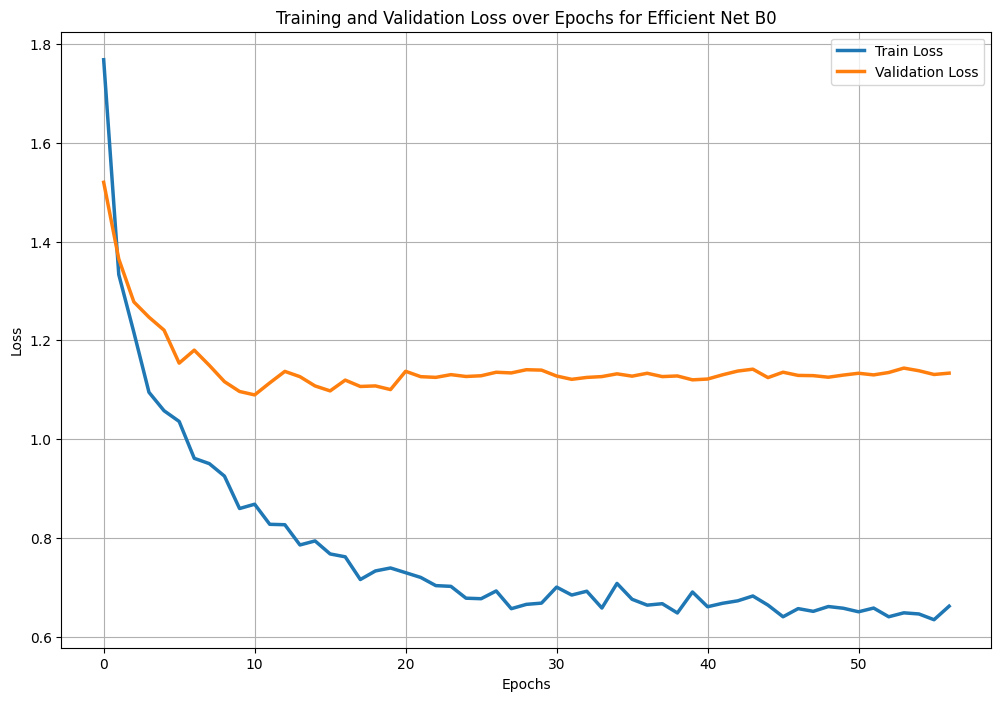

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(history_efficientnet.history['loss'], label='Train Loss', linewidth=2.5)
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title("Training and Validation Loss over Epochs for Efficient Net B0")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **VGG16** - Training & Summary
---

In [39]:
weights_path_vgg16 = '/kaggle/input/vgg16w/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

class_names = sorted(os.listdir('/kaggle/working/RealWasteSplit/train'))
num_classes = len(class_names)
print(f"Number of Classes Detected: {num_classes}")

base_model_vgg16 = VGG16(
    weights=None,  
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model_vgg16.load_weights(weights_path_vgg16)

for layer in base_model_vgg16.layers:
    layer.trainable = False

input_layer_vgg16 = tf.keras.layers.Input(shape=(224, 224, 3))
augmented_input_vgg16 = augmentation_layer(input_layer_vgg16)  # Applying Augmentation
preprocessed_input_vgg16 = tf.keras.applications.vgg16.preprocess_input(augmented_input_vgg16)
feature_extractor_vgg16 = base_model_vgg16(preprocessed_input_vgg16, training=False)

x_vgg16 = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor_vgg16)
x_vgg16 = tf.keras.layers.Dense(256, kernel_regularizer=l2(0.0001))(x_vgg16)
x_vgg16 = tf.keras.layers.BatchNormalization()(x_vgg16)
x_vgg16 = tf.keras.layers.ReLU()(x_vgg16)
x_vgg16 = tf.keras.layers.Dropout(0.2)(x_vgg16)
output_layer_vgg16 = tf.keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x_vgg16)

vgg16_model = tf.keras.models.Model(inputs=input_layer_vgg16, outputs=output_layer_vgg16)

vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr_callback_vgg16 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

early_stopping_callback_vgg16 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
    verbose=1,
    start_from_epoch=50  
)

checkpoint_callback_vgg16 = ModelCheckpoint(
    "best_vgg16_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

train_dataset_vgg16 = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset_vgg16 = val_dataset.prefetch(tf.data.AUTOTUNE)

history_vgg16 = vgg16_model.fit(
    train_dataset_vgg16,
    epochs=100,
    validation_data=val_dataset_vgg16,
    callbacks=[early_stopping_callback_vgg16, reduce_lr_callback_vgg16, checkpoint_callback_vgg16],
    verbose=1
)
vgg16_model.summary()

Number of Classes Detected: 9


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 224, 224, 3)    │              0 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_21 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[5][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_22 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[5][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_23 (GetItem)     │ (None, 224, 224)       │              0 │ sequential_3[5][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_12 (Stack)          │ (None, 224, 224, 3)    │              0 │ get_item_21[0][0],     │
│                           │                        │                │ get_item_22[0][0],     │
│                           │                        │                │ get_item_23[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 224, 224, 3)    │              0 │ stack_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add_7[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 256)            │        131,328 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 256)            │          1,024 │ dense_14[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)            │ (None, 256)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 256)            │              0 │ re_lu_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 9)              │          2,313 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,849,353 (56.65 MB)

 Trainable params: 134,153 (524.04 KB)

 Non-trainable params: 14,715,200 (56.13 MB)

Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2122 - loss: 2.2581
Epoch 1: val_loss improved from inf to 1.67060, saving model to best_vgg16_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - accuracy: 0.2123 - loss: 2.2576 - val_accuracy: 0.4524 - val_loss: 1.6706 - learning_rate: 1.0000e-04
Epoch 2/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4753 - loss: 1.5500
Epoch 2: val_loss improved from 1.67060 to 1.40971, saving model to best_vgg16_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - accuracy: 0.4754 - loss: 1.5498 - val_accuracy: 0.5476 - val_loss: 1.4097 - learning_rate: 1.0000e-04
Epoch 3/100
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5577 - loss: 1.3094
Epoch 3: val_loss improved from 1.40971 to 1.31874, saving model to best_vgg16_model.keras
609/609 ━━━━━━━━━━━━━━━━━━━━ 57s 93ms/step - accuracy: 0.5578 - loss: 1.3092 - val_accuracy: 0.5860 - val_loss: 1.3187 - learning_rate: 1.0000e-04
Epoch 4/100
608/609 ━━━━━━

In [41]:
best_vgg16_model = tf.keras.models.load_model("best_vgg16_model.keras")

def evaluate_model(model, dataset, set_name="Set"):
    y_true = []
    y_pred = []
    y_pred_prob = []

    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        y_true.append(labels)
        y_pred_prob.append(predictions)
        y_pred.append(np.argmax(predictions, axis=1))
    
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)

    y_true_labels = np.argmax(y_true, axis=1)

    accuracy = accuracy_score(y_true_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true_labels, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr')
    except ValueError:
        auc = 0.0  

    return [set_name, f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}", f"{auc:.4f}"]

eval_train_dataset_vgg16 = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

train_results_vgg16 = evaluate_model(best_vgg16_model, eval_train_dataset_vgg16, "Training Set")
val_results_vgg16 = evaluate_model(best_vgg16_model, val_dataset, "Validation Set")
test_results_vgg16 = evaluate_model(best_vgg16_model, test_dataset, "Test Set")

results_table_vgg16 = [train_results_vgg16, val_results_vgg16, test_results_vgg16]
print("\nFinal Model Performance Summary (VGG16):")
print(tabulate(results_table_vgg16, headers=["Set", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"], tablefmt="fancy_grid"))

Found 3042 files belonging to 9 classes.

Final Model Performance Summary (VGG16):
╒════════════════╤════════════╤═════════════╤══════════╤════════════╤════════╕
│ Set            │   Accuracy │   Precision │   Recall │   F1 Score │    AUC │
╞════════════════╪════════════╪═════════════╪══════════╪════════════╪════════╡
│ Training Set   │     0.8314 │      0.8429 │   0.8314 │     0.8316 │ 0.9855 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Validation Set │     0.7063 │      0.731  │   0.7063 │     0.7004 │ 0.9529 │
├────────────────┼────────────┼─────────────┼──────────┼────────────┼────────┤
│ Test Set       │     0.7034 │      0.7177 │   0.7034 │     0.6968 │ 0.9514 │
╘════════════════╧════════════╧═════════════╧══════════╧════════════╧════════╛


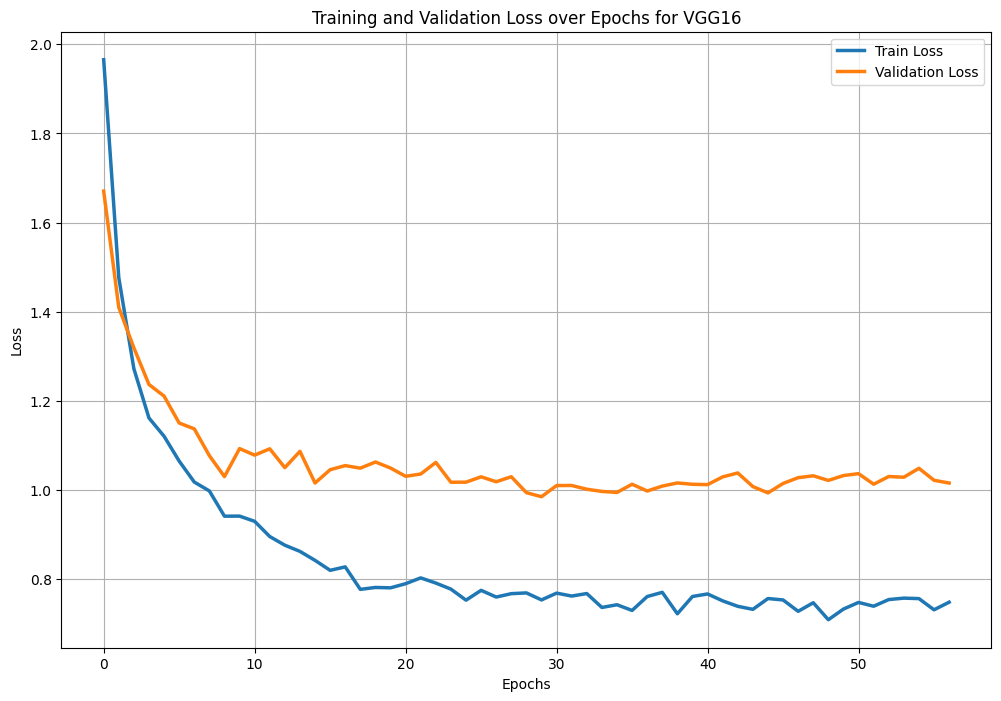

In [63]:
plt.figure(figsize=(12, 8))
plt.plot(history_vgg16.history['loss'], label='Train Loss', linewidth=2.5)
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title("Training and Validation Loss over Epochs for VGG16")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **(v) Comaprison Across All Models**

- I have separated the model evaluation process entirely from the training phase.  
- After training each model, I saved them as `.keras` files locally and then re-uploaded them for evaluation.  
- This approach might result in some redundant code, but it was necessary due to running out of session time on Kaggle.  
- All the evaluation tasks begin in the cells below.  

In [20]:
eval_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

eval_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

eval_test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=24
)

Found 3042 files belonging to 9 classes.
Found 756 files belonging to 9 classes.
Found 954 files belonging to 9 classes.


## **ResNet50**
---

In [28]:
best_resnet50_model = tf.keras.models.load_model("/kaggle/input/myresnet50/best_resnet50_model.keras")

In [21]:
print("\n ResNet50 Training Set Metrics\n")

train_true_resnet50 = []
train_pred_resnet50 = []
train_probs_resnet50 = []

for images, labels in eval_train_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    train_true_resnet50.append(labels_true)
    predictions_probs = best_resnet50_model.predict(images, verbose=0)
    train_probs_resnet50.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    train_pred_resnet50.append(predicted_labels)

y_true_train_resnet50 = np.concatenate(train_true_resnet50)
y_pred_train_resnet50 = np.concatenate(train_pred_resnet50)
y_prob_train_resnet50 = np.concatenate(train_probs_resnet50)

from sklearn.metrics import classification_report, roc_auc_score

print("\nTraining Set Classification Report:\n")
print(classification_report(y_true_train_resnet50, y_pred_train_resnet50, target_names=class_names, digits=4))

# AUC Calculation for Training Set
macro_auc_train_resnet50 = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_resnet50), y_prob_train_resnet50, multi_class='ovr', average='macro')
weighted_auc_train_resnet50 = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_resnet50), y_prob_train_resnet50, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Training Set: {macro_auc_train_resnet50:.4f}")
print(f"Weighted-Average AUC (OvR) for Training Set: {weighted_auc_train_resnet50:.4f}")


 ResNet50 Training Set Metrics


Training Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.7500    0.8949    0.8161       295
      2-Food Organics     0.8653    0.9772    0.9179       263
              3-Glass     0.8866    0.8141    0.8488       269
              4-Metal     0.8022    0.8814    0.8399       506
5-Miscellaneous Trash     0.8856    0.5615    0.6873       317
              6-Paper     0.8799    0.7781    0.8259       320
            7-Plastic     0.8468    0.7980    0.8217       589
      8-Textile Trash     0.7835    0.8873    0.8322       204
         9-Vegetation     0.8531    0.9785    0.9115       279

             accuracy                         0.8340      3042
            macro avg     0.8392    0.8412    0.8335      3042
         weighted avg     0.8390    0.8340    0.8303      3042


Macro-Average AUC (OvR) for Training Set: 0.9856
Weighted-Average AUC (OvR) for Training Set: 0.9839


In [22]:
print("\n ResNet50 Validation Set Metrics\n")

val_true_resnet50 = []
val_pred_resnet50 = []
val_probs_resnet50 = []

for images, labels in eval_val_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    val_true_resnet50.append(labels_true)
    predictions_probs = best_resnet50_model.predict(images, verbose=0)
    val_probs_resnet50.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    val_pred_resnet50.append(predicted_labels)

y_true_val_resnet50 = np.concatenate(val_true_resnet50)
y_pred_val_resnet50 = np.concatenate(val_pred_resnet50)
y_prob_val_resnet50 = np.concatenate(val_probs_resnet50)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_true_val_resnet50, y_pred_val_resnet50, target_names=class_names, digits=4))

# AUC Calculation for Validation Set
macro_auc_val_resnet50 = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_resnet50), y_prob_val_resnet50, multi_class='ovr', average='macro')
weighted_auc_val_resnet50 = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_resnet50), y_prob_val_resnet50, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Validation Set: {macro_auc_val_resnet50:.4f}")
print(f"Weighted-Average AUC (OvR) for Validation Set: {weighted_auc_val_resnet50:.4f}")


 ResNet50 Validation Set Metrics


Validation Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.7528    0.9178    0.8272        73
      2-Food Organics     0.5376    0.7692    0.6329        65
              3-Glass     0.8621    0.3731    0.5208        67
              4-Metal     0.7535    0.8492    0.7985       126
5-Miscellaneous Trash     0.3333    0.1266    0.1835        79
              6-Paper     0.8906    0.7125    0.7917        80
            7-Plastic     0.6951    0.7755    0.7331       147
      8-Textile Trash     0.7193    0.8200    0.7664        50
         9-Vegetation     0.7614    0.9710    0.8535        69

             accuracy                         0.7116       756
            macro avg     0.7006    0.7017    0.6786       756
         weighted avg     0.7022    0.7116    0.6876       756


Macro-Average AUC (OvR) for Validation Set: 0.9565
Weighted-Average AUC (OvR) for Validation Set: 0.95

In [23]:
print("\nResNet50 Test Set Metrics\n")

test_true_resnet50 = []
test_pred_resnet50 = []
test_probs_resnet50 = []

for images, labels in eval_test_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    test_true_resnet50.append(labels_true)
    predictions_probs = best_resnet50_model.predict(images, verbose=0)
    test_probs_resnet50.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    test_pred_resnet50.append(predicted_labels)

y_true_test_resnet50 = np.concatenate(test_true_resnet50)
y_pred_test_resnet50 = np.concatenate(test_pred_resnet50)
y_prob_test_resnet50 = np.concatenate(test_probs_resnet50)

print("\nTest Set Classification Report:\n")
print(classification_report(y_true_test_resnet50, y_pred_test_resnet50, target_names=class_names, digits=4))

# AUC Calculation for Test Set
macro_auc_test_resnet50 = roc_auc_score(tf.keras.utils.to_categorical(y_true_test_resnet50), y_prob_test_resnet50, multi_class='ovr', average='macro')
weighted_auc_test_resnet50 = roc_auc_score(tf.keras.utils.to_categorical(y_true_test_resnet50), y_prob_test_resnet50, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Test Set: {macro_auc_test_resnet50:.4f}")
print(f"Weighted-Average AUC (OvR) for Test Set: {weighted_auc_test_resnet50:.4f}")


ResNet50 Test Set Metrics


Test Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.7103    0.8172    0.7600        93
      2-Food Organics     0.7128    0.8072    0.7571        83
              3-Glass     0.7736    0.4881    0.5985        84
              4-Metal     0.6923    0.8544    0.7649       158
5-Miscellaneous Trash     0.6444    0.2929    0.4028        99
              6-Paper     0.8641    0.8900    0.8768       100
            7-Plastic     0.7400    0.8000    0.7688       185
      8-Textile Trash     0.7377    0.7031    0.7200        64
         9-Vegetation     0.8021    0.8750    0.8370        88

             accuracy                         0.7411       954
            macro avg     0.7419    0.7253    0.7207       954
         weighted avg     0.7385    0.7411    0.7276       954


Macro-Average AUC (OvR) for Test Set: 0.9600
Weighted-Average AUC (OvR) for Test Set: 0.9598


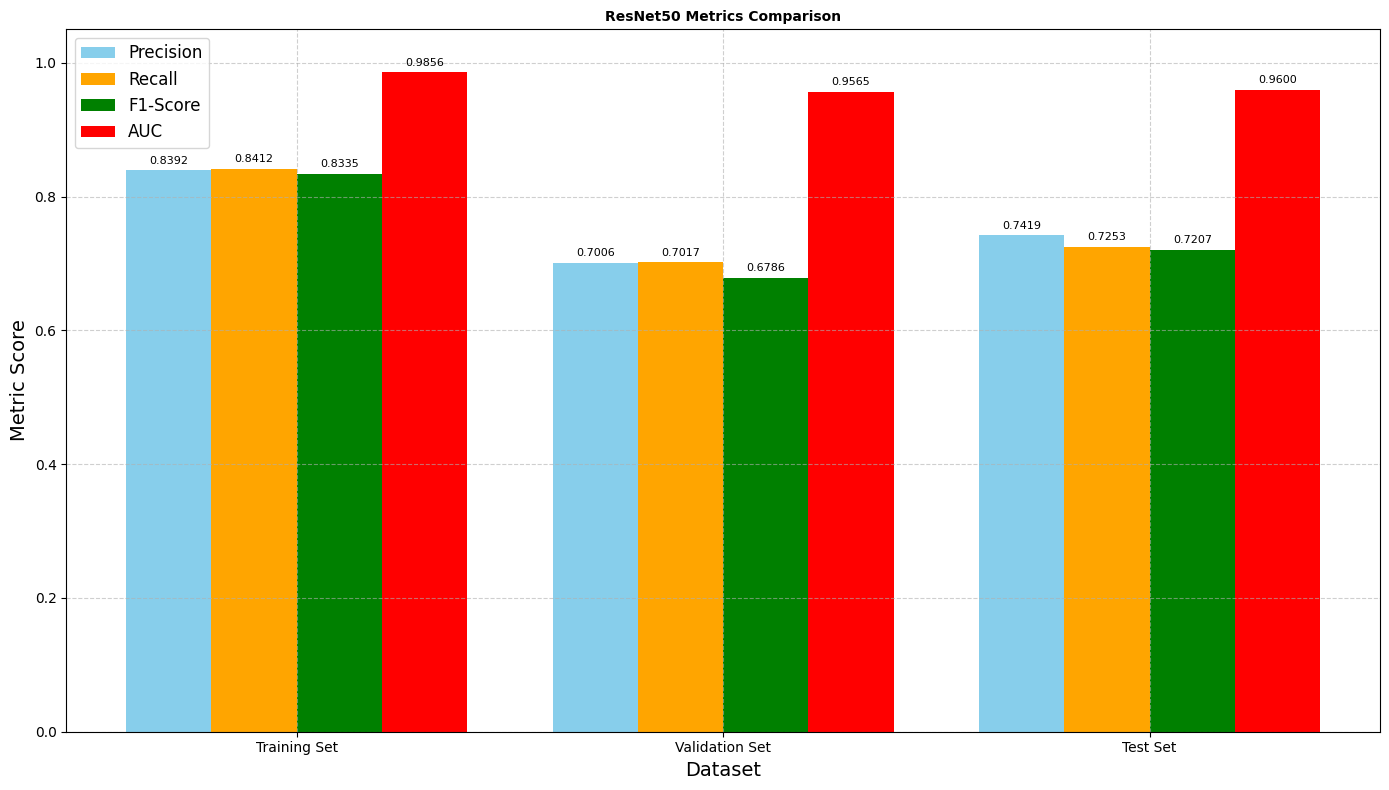

In [38]:
datasets = ['Training Set', 'Validation Set', 'Test Set']

precision_values = [0.8392, 0.7006, 0.7419]
recall_values = [0.8412, 0.7017, 0.7253]
f1_values = [0.8335, 0.6786, 0.7207]
auc_values = [0.9856, 0.9565, 0.9600]

bar_width = 0.2
index = np.arange(len(datasets))

plt.figure(figsize=(14, 8))
plt.bar(index - 1.5 * bar_width, precision_values, bar_width, label='Precision', color='skyblue')
plt.bar(index - 0.5 * bar_width, recall_values, bar_width, label='Recall', color='orange')
plt.bar(index + 0.5 * bar_width, f1_values, bar_width, label='F1-Score', color='green')
plt.bar(index + 1.5 * bar_width, auc_values, bar_width, label='AUC', color='red')

for i in range(len(datasets)):
    plt.text(i - 1.5 * bar_width, precision_values[i] + 0.01, f'{precision_values[i]:.4f}', ha='center', fontsize=8)
    plt.text(i - 0.5 * bar_width, recall_values[i] + 0.01, f'{recall_values[i]:.4f}', ha='center', fontsize=8)
    plt.text(i + 0.5 * bar_width, f1_values[i] + 0.01, f'{f1_values[i]:.4f}', ha='center', fontsize=8)
    plt.text(i + 1.5 * bar_width, auc_values[i] + 0.01, f'{auc_values[i]:.4f}', ha='center', fontsize=8)

plt.title("ResNet50 Metrics Comparison", fontsize=10, fontweight='bold')
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.ylim(0.0, 1.05)
plt.xticks(index, datasets)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## **ResNet101**
---

In [32]:
best_resnet101_model = tf.keras.models.load_model("/kaggle/input/myresnet101/best_resnet101_model.keras")

In [33]:
print("\nResNet101 Training Set Metrics\n")

train_true_resnet101 = []
train_pred_resnet101 = []
train_probs_resnet101 = []

for images, labels in eval_train_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    train_true_resnet101.append(labels_true)
    predictions_probs = best_resnet101_model.predict(images, verbose=0)
    train_probs_resnet101.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    train_pred_resnet101.append(predicted_labels)

y_true_train_resnet101 = np.concatenate(train_true_resnet101)
y_pred_train_resnet101 = np.concatenate(train_pred_resnet101)
y_prob_train_resnet101 = np.concatenate(train_probs_resnet101)

from sklearn.metrics import classification_report, roc_auc_score

print("\nTraining Set Classification Report:\n")
print(classification_report(y_true_train_resnet101, y_pred_train_resnet101, target_names=class_names, digits=4))

# AUC Calculation for Training Set
macro_auc_train_resnet101 = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_resnet101), y_prob_train_resnet101, multi_class='ovr', average='macro')
weighted_auc_train_resnet101 = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_resnet101), y_prob_train_resnet101, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Training Set: {macro_auc_train_resnet101:.4f}")
print(f"Weighted-Average AUC (OvR) for Training Set: {weighted_auc_train_resnet101:.4f}")


ResNet101 Training Set Metrics


Training Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.7584    0.9898    0.8588       295
      2-Food Organics     0.9384    0.9848    0.9610       263
              3-Glass     0.9759    0.9033    0.9382       269
              4-Metal     0.9316    0.9427    0.9371       506
5-Miscellaneous Trash     0.9537    0.8454    0.8963       317
              6-Paper     0.9887    0.8219    0.8976       320
            7-Plastic     0.9404    0.9100    0.9249       589
      8-Textile Trash     0.9590    0.9167    0.9373       204
         9-Vegetation     0.8994    0.9928    0.9438       279

             accuracy                         0.9211      3042
            macro avg     0.9273    0.9231    0.9217      3042
         weighted avg     0.9282    0.9211    0.9216      3042


Macro-Average AUC (OvR) for Training Set: 0.9970
Weighted-Average AUC (OvR) for Training Set: 0.9965


In [35]:
print("\nResNet101 Validation Set Metrics\n")

val_true_resnet101 = []
val_pred_resnet101 = []
val_probs_resnet101 = []

for images, labels in eval_val_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    val_true_resnet101.append(labels_true)
    predictions_probs = best_resnet101_model.predict(images, verbose=0)
    val_probs_resnet101.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    val_pred_resnet101.append(predicted_labels)

y_true_val_resnet101 = np.concatenate(val_true_resnet101)
y_pred_val_resnet101 = np.concatenate(val_pred_resnet101)
y_prob_val_resnet101 = np.concatenate(val_probs_resnet101)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_true_val_resnet101, y_pred_val_resnet101, target_names=class_names, digits=4))

# AUC Calculation for Validation Set
macro_auc_val_resnet101 = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_resnet101), y_prob_val_resnet101, multi_class='ovr', average='macro')
weighted_auc_val_resnet101 = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_resnet101), y_prob_val_resnet101, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Validation Set: {macro_auc_val_resnet101:.4f}")
print(f"Weighted-Average AUC (OvR) for Validation Set: {weighted_auc_val_resnet101:.4f}")


ResNet101 Validation Set Metrics


Validation Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.6364    0.9589    0.7650        73
      2-Food Organics     0.6220    0.7846    0.6939        65
              3-Glass     0.9318    0.6119    0.7387        67
              4-Metal     0.8468    0.8333    0.8400       126
5-Miscellaneous Trash     0.4688    0.3797    0.4196        79
              6-Paper     0.9231    0.6000    0.7273        80
            7-Plastic     0.7945    0.7891    0.7918       147
      8-Textile Trash     0.9091    0.8000    0.8511        50
         9-Vegetation     0.6889    0.8986    0.7799        69

             accuracy                         0.7447       756
            macro avg     0.7579    0.7396    0.7341       756
         weighted avg     0.7628    0.7447    0.7412       756


Macro-Average AUC (OvR) for Validation Set: 0.9663
Weighted-Average AUC (OvR) for Validation Set: 0.96

In [36]:
print("\nResNet101 Test Set Metrics\n")

test_true_resnet101 = []
test_pred_resnet101 = []
test_probs_resnet101 = []

for images, labels in eval_test_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    test_true_resnet101.append(labels_true)
    predictions_probs = best_resnet101_model.predict(images, verbose=0)
    test_probs_resnet101.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    test_pred_resnet101.append(predicted_labels)

y_true_test_resnet101 = np.concatenate(test_true_resnet101)
y_pred_test_resnet101 = np.concatenate(test_pred_resnet101)
y_prob_test_resnet101 = np.concatenate(test_probs_resnet101)

print("\nTest Set Classification Report:\n")
print(classification_report(y_true_test_resnet101, y_pred_test_resnet101, target_names=class_names, digits=4))

# AUC Calculation for Test Set
macro_auc_test_resnet101 = roc_auc_score(tf.keras.utils.to_categorical(y_true_test_resnet101), y_prob_test_resnet101, multi_class='ovr', average='macro')
weighted_auc_test_resnet101 = roc_auc_score(tf.keras.utils.to_categorical(y_true_test_resnet101), y_prob_test_resnet101, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Test Set: {macro_auc_test_resnet101:.4f}")
print(f"Weighted-Average AUC (OvR) for Test Set: {weighted_auc_test_resnet101:.4f}")


ResNet101 Test Set Metrics


Test Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.6148    0.8925    0.7281        93
      2-Food Organics     0.8090    0.8675    0.8372        83
              3-Glass     0.7826    0.4286    0.5538        84
              4-Metal     0.7418    0.8544    0.7941       158
5-Miscellaneous Trash     0.5857    0.4141    0.4852        99
              6-Paper     0.9059    0.7700    0.8324       100
            7-Plastic     0.7766    0.8270    0.8010       185
      8-Textile Trash     0.8667    0.6094    0.7156        64
         9-Vegetation     0.7810    0.9318    0.8497        88

             accuracy                         0.7526       954
            macro avg     0.7627    0.7328    0.7330       954
         weighted avg     0.7586    0.7526    0.7434       954


Macro-Average AUC (OvR) for Test Set: 0.9717
Weighted-Average AUC (OvR) for Test Set: 0.9703


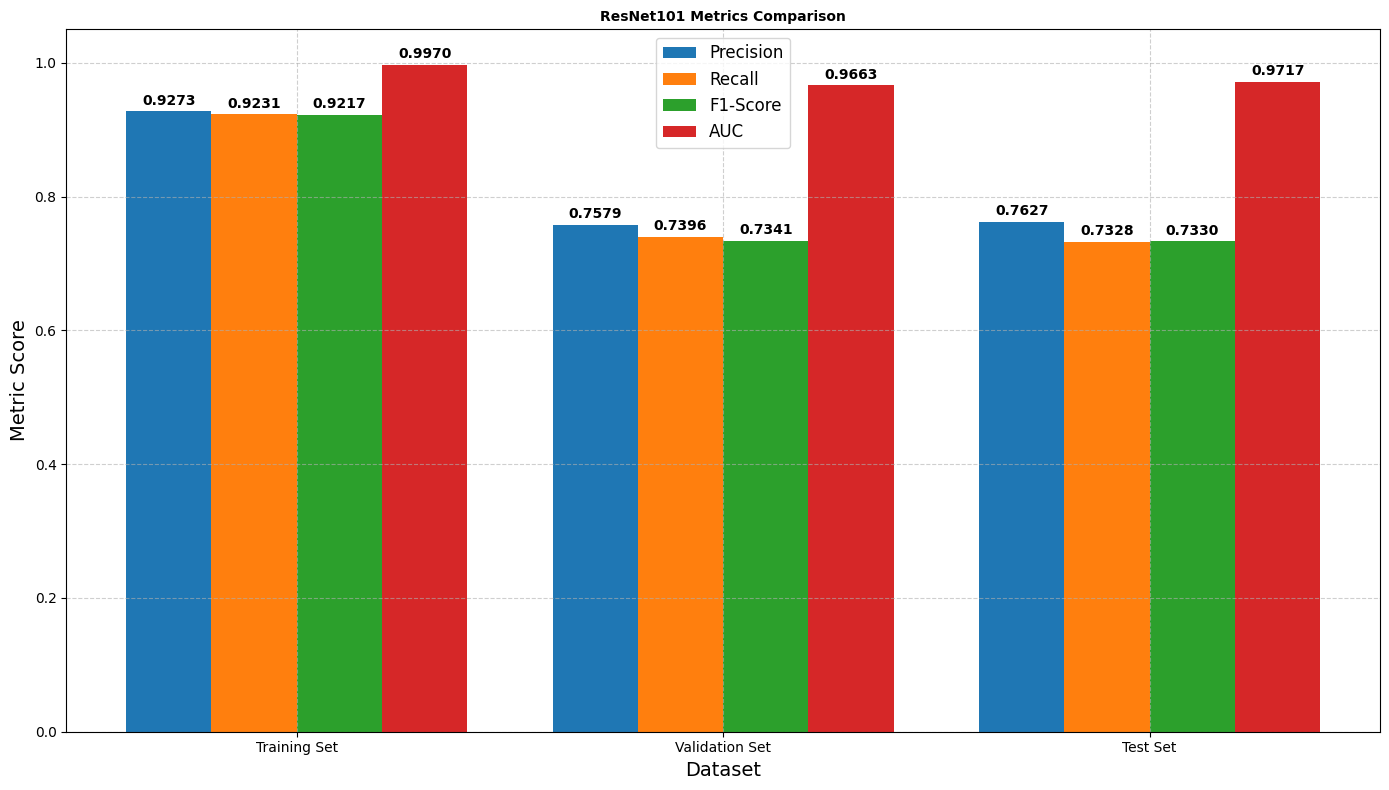

In [40]:
datasets = ['Training Set', 'Validation Set', 'Test Set']

precision_values = [0.9273, 0.7579, 0.7627]
recall_values = [0.9231, 0.7396, 0.7328]
f1_values = [0.9217, 0.7341, 0.7330]
auc_values = [0.9970, 0.9663, 0.9717]

bar_width = 0.2
index = np.arange(len(datasets))

plt.figure(figsize=(14, 8))
plt.bar(index - 1.5 * bar_width, precision_values, bar_width, label='Precision', color='#1f77b4')
plt.bar(index - 0.5 * bar_width, recall_values, bar_width, label='Recall', color='#ff7f0e')
plt.bar(index + 0.5 * bar_width, f1_values, bar_width, label='F1-Score', color='#2ca02c')
plt.bar(index + 1.5 * bar_width, auc_values, bar_width, label='AUC', color='#d62728')

for i in range(len(datasets)):
    plt.text(i - 1.5 * bar_width, precision_values[i] + 0.01, f'{precision_values[i]:.4f}', ha='center', fontsize=10, fontweight='bold')
    plt.text(i - 0.5 * bar_width, recall_values[i] + 0.01, f'{recall_values[i]:.4f}', ha='center', fontsize=10, fontweight='bold')
    plt.text(i + 0.5 * bar_width, f1_values[i] + 0.01, f'{f1_values[i]:.4f}', ha='center', fontsize=10, fontweight='bold')
    plt.text(i + 1.5 * bar_width, auc_values[i] + 0.01, f'{auc_values[i]:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.title("ResNet101 Metrics Comparison", fontsize=10, fontweight='bold')
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.ylim(0.0, 1.05)
plt.xticks(index, datasets)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## **EfficientNetB0**
---

In [41]:
best_efficientnet_model = tf.keras.models.load_model("/kaggle/input/myeffnet/best_efficientnet_model.keras")

In [42]:
print("\nEfficientNetB0 Training Set Metrics\n")

train_true_effnet = []
train_pred_effnet = []
train_probs_effnet = []

for images, labels in eval_train_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    train_true_effnet.append(labels_true)
    predictions_probs = best_efficientnet_model.predict(images, verbose=0)
    train_probs_effnet.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    train_pred_effnet.append(predicted_labels)

y_true_train_effnet = np.concatenate(train_true_effnet)
y_pred_train_effnet = np.concatenate(train_pred_effnet)
y_prob_train_effnet = np.concatenate(train_probs_effnet)

print("\nTraining Set Classification Report:\n")
print(classification_report(y_true_train_effnet, y_pred_train_effnet, target_names=class_names, digits=4))

# AUC Calculation for Training Set
macro_auc_train_effnet = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_effnet), y_prob_train_effnet, multi_class='ovr', average='macro')
weighted_auc_train_effnet = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_effnet), y_prob_train_effnet, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Training Set: {macro_auc_train_effnet:.4f}")
print(f"Weighted-Average AUC (OvR) for Training Set: {weighted_auc_train_effnet:.4f}")


EfficientNetB0 Training Set Metrics


Training Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.4880    0.7593    0.5942       295
      2-Food Organics     0.6720    0.9582    0.7900       263
              3-Glass     0.8125    0.2416    0.3725       269
              4-Metal     0.6462    0.8518    0.7349       506
5-Miscellaneous Trash     0.6242    0.6183    0.6212       317
              6-Paper     0.8267    0.5219    0.6398       320
            7-Plastic     0.7849    0.6010    0.6808       589
      8-Textile Trash     0.8173    0.8333    0.8252       204
         9-Vegetation     0.7937    0.8136    0.8035       279

             accuracy                         0.6857      3042
            macro avg     0.7184    0.6888    0.6736      3042
         weighted avg     0.7164    0.6857    0.6740      3042


Macro-Average AUC (OvR) for Training Set: 0.9564
Weighted-Average AUC (OvR) for Training Set: 0.9530


In [43]:
print("\nEfficientNetB0 Validation Set Metrics\n")

val_true_effnet = []
val_pred_effnet = []
val_probs_effnet = []

for images, labels in eval_val_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    val_true_effnet.append(labels_true)
    predictions_probs = best_efficientnet_model.predict(images, verbose=0)
    val_probs_effnet.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    val_pred_effnet.append(predicted_labels)

y_true_val_effnet = np.concatenate(val_true_effnet)
y_pred_val_effnet = np.concatenate(val_pred_effnet)
y_prob_val_effnet = np.concatenate(val_probs_effnet)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_true_val_effnet, y_pred_val_effnet, target_names=class_names, digits=4))

# AUC Calculation for Validation Set
macro_auc_val_effnet = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_effnet), y_prob_val_effnet, multi_class='ovr', average='macro')
weighted_auc_val_effnet = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_effnet), y_prob_val_effnet, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Validation Set: {macro_auc_val_effnet:.4f}")
print(f"Weighted-Average AUC (OvR) for Validation Set: {weighted_auc_val_effnet:.4f}")


EfficientNetB0 Validation Set Metrics


Validation Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.4660    0.6575    0.5455        73
      2-Food Organics     0.4878    0.9231    0.6383        65
              3-Glass     0.9474    0.2687    0.4186        67
              4-Metal     0.6541    0.8254    0.7298       126
5-Miscellaneous Trash     0.3333    0.3291    0.3312        79
              6-Paper     0.7451    0.4750    0.5802        80
            7-Plastic     0.7589    0.5782    0.6564       147
      8-Textile Trash     0.7619    0.6400    0.6957        50
         9-Vegetation     0.7681    0.7681    0.7681        69

             accuracy                         0.6138       756
            macro avg     0.6581    0.6072    0.5960       756
         weighted avg     0.6617    0.6138    0.6060       756


Macro-Average AUC (OvR) for Validation Set: 0.9264
Weighted-Average AUC (OvR) for Validation Set:

In [44]:
print("\nEfficientNetB0 Validation Set Metrics\n")

val_true_effnet = []
val_pred_effnet = []
val_probs_effnet = []

for images, labels in eval_val_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    val_true_effnet.append(labels_true)
    predictions_probs = best_efficientnet_model.predict(images, verbose=0)
    val_probs_effnet.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    val_pred_effnet.append(predicted_labels)

y_true_val_effnet = np.concatenate(val_true_effnet)
y_pred_val_effnet = np.concatenate(val_pred_effnet)
y_prob_val_effnet = np.concatenate(val_probs_effnet)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_true_val_effnet, y_pred_val_effnet, target_names=class_names, digits=4))

# AUC Calculation for Validation Set
macro_auc_val_effnet = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_effnet), y_prob_val_effnet, multi_class='ovr', average='macro')
weighted_auc_val_effnet = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_effnet), y_prob_val_effnet, multi_class='ovr', average='weighted')
print(f"\nMacro-Average AUC (OvR) for Validation Set: {macro_auc_val_effnet:.4f}")
print(f"Weighted-Average AUC (OvR) for Validation Set: {weighted_auc_val_effnet:.4f}")


EfficientNetB0 Validation Set Metrics


Validation Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.4660    0.6575    0.5455        73
      2-Food Organics     0.4878    0.9231    0.6383        65
              3-Glass     0.9474    0.2687    0.4186        67
              4-Metal     0.6541    0.8254    0.7298       126
5-Miscellaneous Trash     0.3333    0.3291    0.3312        79
              6-Paper     0.7451    0.4750    0.5802        80
            7-Plastic     0.7589    0.5782    0.6564       147
      8-Textile Trash     0.7619    0.6400    0.6957        50
         9-Vegetation     0.7681    0.7681    0.7681        69

             accuracy                         0.6138       756
            macro avg     0.6581    0.6072    0.5960       756
         weighted avg     0.6617    0.6138    0.6060       756


Macro-Average AUC (OvR) for Validation Set: 0.9264
Weighted-Average AUC (OvR) for Validation Set:

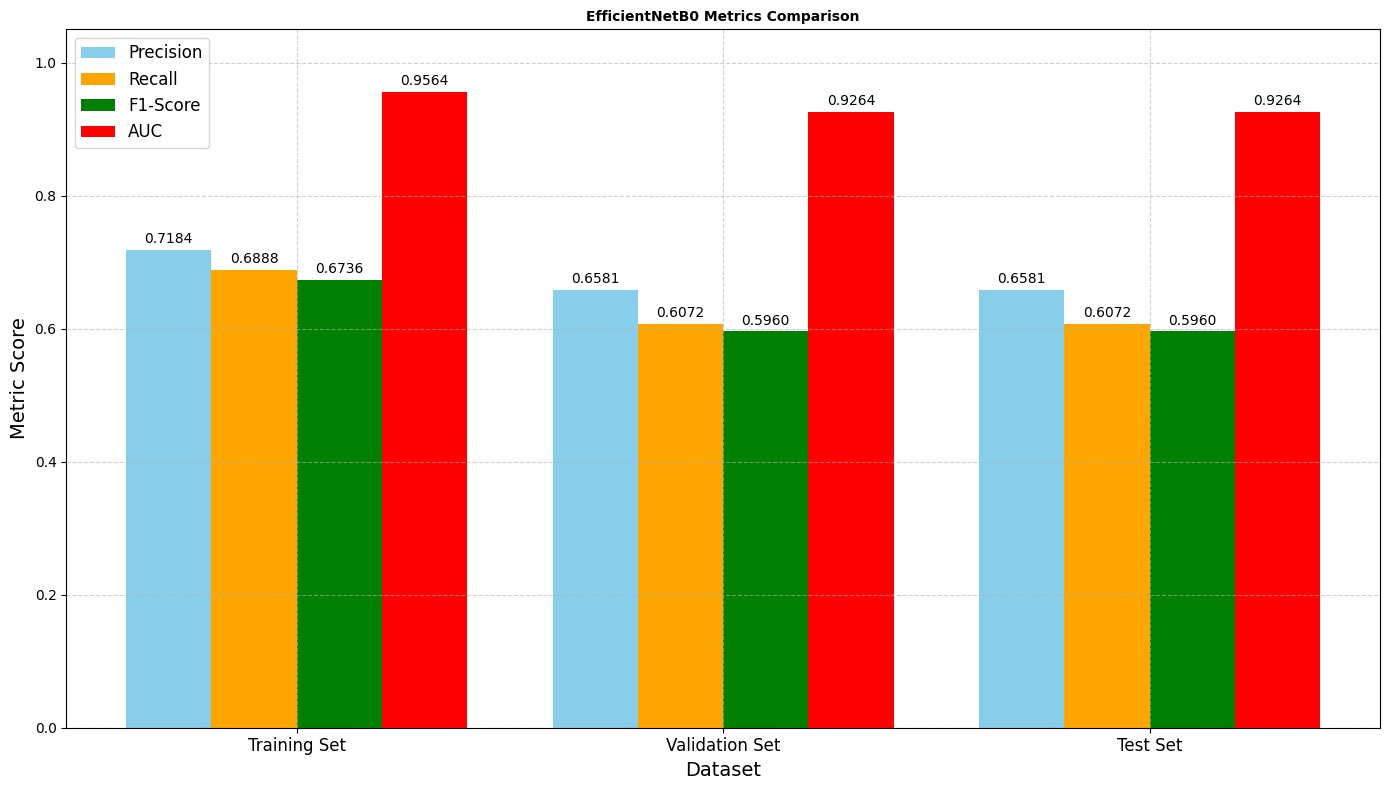

In [46]:
datasets = ['Training Set', 'Validation Set', 'Test Set']

precision_values_effnet = [0.7184, 0.6581, 0.6581]
recall_values_effnet = [0.6888, 0.6072, 0.6072]
f1_values_effnet = [0.6736, 0.5960, 0.5960]
auc_values_effnet = [0.9564, 0.9264, 0.9264]

bar_width = 0.2
index = np.arange(len(datasets))

plt.figure(figsize=(14, 8))
plt.bar(index - 1.5 * bar_width, precision_values_effnet, bar_width, label='Precision', color='skyblue')
plt.bar(index - 0.5 * bar_width, recall_values_effnet, bar_width, label='Recall', color='orange')
plt.bar(index + 0.5 * bar_width, f1_values_effnet, bar_width, label='F1-Score', color='green')
plt.bar(index + 1.5 * bar_width, auc_values_effnet, bar_width, label='AUC', color='red')

for i in range(len(datasets)):
    plt.text(i - 1.5 * bar_width, precision_values_effnet[i] + 0.01, f'{precision_values_effnet[i]:.4f}', ha='center', fontsize=10)
    plt.text(i - 0.5 * bar_width, recall_values_effnet[i] + 0.01, f'{recall_values_effnet[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + 0.5 * bar_width, f1_values_effnet[i] + 0.01, f'{f1_values_effnet[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + 1.5 * bar_width, auc_values_effnet[i] + 0.01, f'{auc_values_effnet[i]:.4f}', ha='center', fontsize=10)

plt.title("EfficientNetB0 Metrics Comparison", fontsize=10, fontweight='bold')
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.ylim(0.0, 1.05)
plt.xticks(index, datasets, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## **VGG16**
---

In [47]:
best_vgg16_model = tf.keras.models.load_model("/kaggle/input/myvgg16/best_vgg16_model.keras")

In [48]:
print("\nVGG16 Training Set Metrics\n")

train_true_vgg16 = []
train_pred_vgg16 = []
train_probs_vgg16 = []

for images, labels in eval_train_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    train_true_vgg16.append(labels_true)
    predictions_probs = best_vgg16_model.predict(images, verbose=0)
    train_probs_vgg16.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    train_pred_vgg16.append(predicted_labels)

y_true_train_vgg16 = np.concatenate(train_true_vgg16)
y_pred_train_vgg16 = np.concatenate(train_pred_vgg16)
y_prob_train_vgg16 = np.concatenate(train_probs_vgg16)

print("\nTraining Set Classification Report:\n")
print(classification_report(y_true_train_vgg16, y_pred_train_vgg16, target_names=class_names, digits=4))

macro_auc_train_vgg16 = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_vgg16), y_prob_train_vgg16, multi_class='ovr', average='macro')
weighted_auc_train_vgg16 = roc_auc_score(tf.keras.utils.to_categorical(y_true_train_vgg16), y_prob_train_vgg16, multi_class='ovr', average='weighted')

print(f"\nMacro-Average AUC (OvR) for Training Set: {macro_auc_train_vgg16:.4f}")
print(f"Weighted-Average AUC (OvR) for Training Set: {weighted_auc_train_vgg16:.4f}")


VGG16 Training Set Metrics


Training Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.6979    0.9085    0.7894       295
      2-Food Organics     0.7205    1.0000    0.8376       263
              3-Glass     0.8735    0.8216    0.8467       269
              4-Metal     0.8444    0.8577    0.8510       506
5-Miscellaneous Trash     0.8471    0.6814    0.7552       317
              6-Paper     0.8733    0.8187    0.8452       320
            7-Plastic     0.8579    0.8098    0.8332       589
      8-Textile Trash     0.8789    0.8186    0.8477       204
         9-Vegetation     0.9822    0.7921    0.8770       279

             accuracy                         0.8314      3042
            macro avg     0.8418    0.8343    0.8314      3042
         weighted avg     0.8429    0.8314    0.8316      3042


Macro-Average AUC (OvR) for Training Set: 0.9855
Weighted-Average AUC (OvR) for Training Set: 0.9845


In [50]:
print("\nVGG16 Validation Set Metrics\n")

val_true_vgg16 = []
val_pred_vgg16 = []
val_probs_vgg16 = []

for images, labels in eval_val_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    val_true_vgg16.append(labels_true)
    predictions_probs = best_vgg16_model.predict(images, verbose=0)
    val_probs_vgg16.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    val_pred_vgg16.append(predicted_labels)

y_true_val_vgg16 = np.concatenate(val_true_vgg16)
y_pred_val_vgg16 = np.concatenate(val_pred_vgg16)
y_prob_val_vgg16 = np.concatenate(val_probs_vgg16)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_true_val_vgg16, y_pred_val_vgg16, target_names=class_names, digits=4))

macro_auc_val_vgg16 = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_vgg16), y_prob_val_vgg16, multi_class='ovr', average='macro')
weighted_auc_val_vgg16 = roc_auc_score(tf.keras.utils.to_categorical(y_true_val_vgg16), y_prob_val_vgg16, multi_class='ovr', average='weighted')

print(f"\nMacro-Average AUC (OvR) for Validation Set: {macro_auc_val_vgg16:.4f}")
print(f"Weighted-Average AUC (OvR) for Validation Set: {weighted_auc_val_vgg16:.4f}")


VGG16 Validation Set Metrics


Validation Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.6700    0.9178    0.7746        73
      2-Food Organics     0.4923    0.9846    0.6564        65
              3-Glass     0.7250    0.4328    0.5421        67
              4-Metal     0.8115    0.7857    0.7984       126
5-Miscellaneous Trash     0.4902    0.3165    0.3846        79
              6-Paper     0.8696    0.7500    0.8054        80
            7-Plastic     0.7044    0.7619    0.7320       147
      8-Textile Trash     0.8286    0.5800    0.6824        50
         9-Vegetation     0.9800    0.7101    0.8235        69

             accuracy                         0.7063       756
            macro avg     0.7302    0.6933    0.6888       756
         weighted avg     0.7310    0.7063    0.7004       756


Macro-Average AUC (OvR) for Validation Set: 0.9529
Weighted-Average AUC (OvR) for Validation Set: 0.9517


In [51]:
print("\nVGG16 Test Set Metrics\n")

test_true_vgg16 = []
test_pred_vgg16 = []
test_probs_vgg16 = []

for images, labels in eval_test_dataset:
    labels_true = np.argmax(labels.numpy(), axis=1)
    test_true_vgg16.append(labels_true)
    predictions_probs = best_vgg16_model.predict(images, verbose=0)
    test_probs_vgg16.append(predictions_probs)
    predicted_labels = np.argmax(predictions_probs, axis=1)
    test_pred_vgg16.append(predicted_labels)

y_true_test_vgg16 = np.concatenate(test_true_vgg16)
y_pred_test_vgg16 = np.concatenate(test_pred_vgg16)
y_prob_test_vgg16 = np.concatenate(test_probs_vgg16)

print("\nTest Set Classification Report:\n")
print(classification_report(y_true_test_vgg16, y_pred_test_vgg16, target_names=class_names, digits=4))

macro_auc_test_vgg16 = roc_auc_score(tf.keras.utils.to_categorical(y_true_test_vgg16), y_prob_test_vgg16, multi_class='ovr', average='macro')
weighted_auc_test_vgg16 = roc_auc_score(tf.keras.utils.to_categorical(y_true_test_vgg16), y_prob_test_vgg16, multi_class='ovr', average='weighted')

print(f"\nMacro-Average AUC (OvR) for Test Set: {macro_auc_test_vgg16:.4f}")
print(f"Weighted-Average AUC (OvR) for Test Set: {weighted_auc_test_vgg16:.4f}")


VGG16 Test Set Metrics


Test Set Classification Report:

                       precision    recall  f1-score   support

          1-Cardboard     0.6288    0.8925    0.7378        93
      2-Food Organics     0.5859    0.9036    0.7109        83
              3-Glass     0.6140    0.4167    0.4965        84
              4-Metal     0.7386    0.8228    0.7784       158
5-Miscellaneous Trash     0.6308    0.4141    0.5000        99
              6-Paper     0.9059    0.7700    0.8324       100
            7-Plastic     0.6716    0.7297    0.6995       185
      8-Textile Trash     0.8039    0.6406    0.7130        64
         9-Vegetation     0.9153    0.6136    0.7347        88

             accuracy                         0.7034       954
            macro avg     0.7217    0.6893    0.6892       954
         weighted avg     0.7177    0.7034    0.6968       954


Macro-Average AUC (OvR) for Test Set: 0.9514
Weighted-Average AUC (OvR) for Test Set: 0.9499


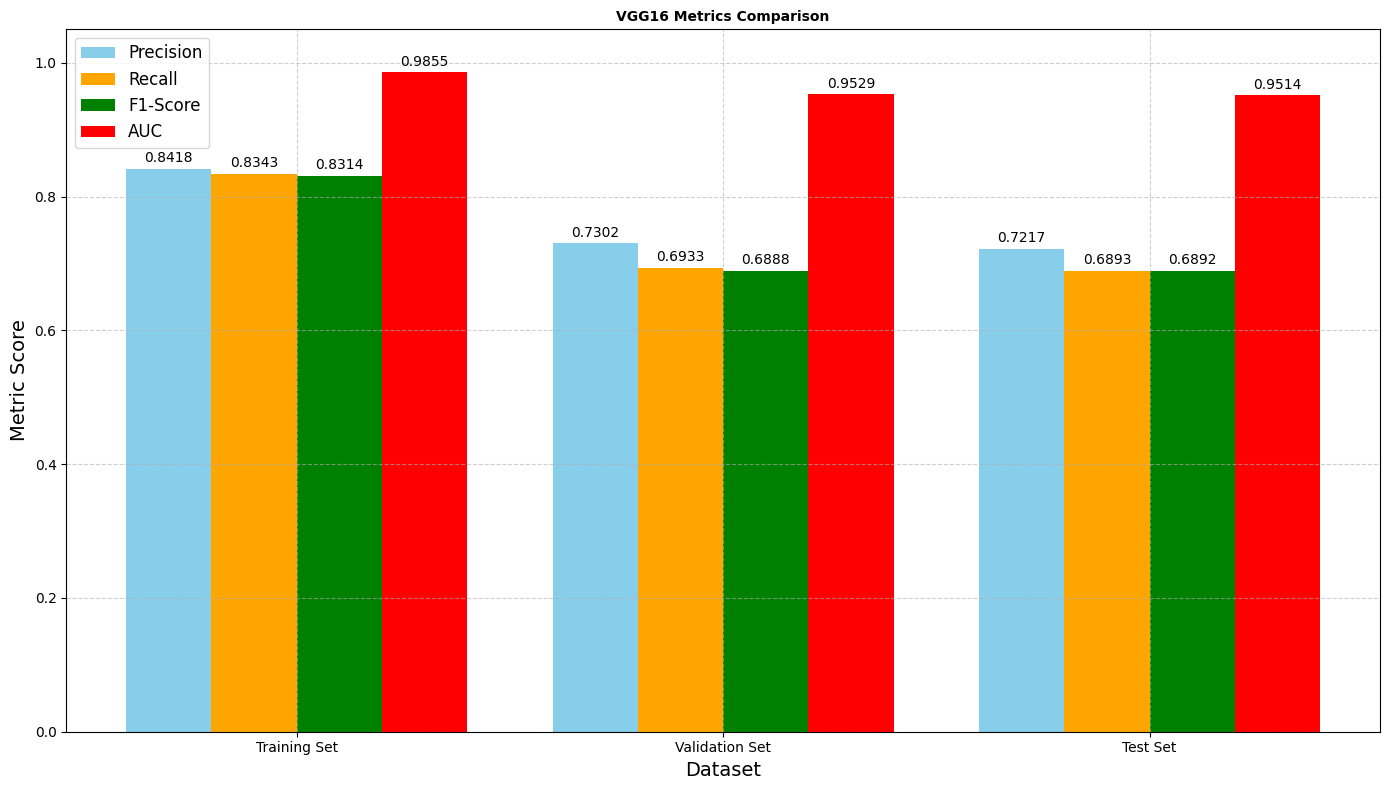

In [53]:
datasets = ['Training Set', 'Validation Set', 'Test Set']

precision_values_vgg16 = [0.8418, 0.7302, 0.7217]
recall_values_vgg16 = [0.8343, 0.6933, 0.6893]
f1_values_vgg16 = [0.8314, 0.6888, 0.6892]
auc_values_vgg16 = [0.9855, 0.9529, 0.9514]

bar_width = 0.2
index = np.arange(len(datasets))

plt.figure(figsize=(14, 8))
plt.bar(index - 1.5 * bar_width, precision_values_vgg16, bar_width, label='Precision', color='skyblue')
plt.bar(index - 0.5 * bar_width, recall_values_vgg16, bar_width, label='Recall', color='orange')
plt.bar(index + 0.5 * bar_width, f1_values_vgg16, bar_width, label='F1-Score', color='green')
plt.bar(index + 1.5 * bar_width, auc_values_vgg16, bar_width, label='AUC', color='red')

for i in range(len(datasets)):
    plt.text(i - 1.5 * bar_width, precision_values_vgg16[i] + 0.01, f'{precision_values_vgg16[i]:.4f}', ha='center', fontsize=10)
    plt.text(i - 0.5 * bar_width, recall_values_vgg16[i] + 0.01, f'{recall_values_vgg16[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + 0.5 * bar_width, f1_values_vgg16[i] + 0.01, f'{f1_values_vgg16[i]:.4f}', ha='center', fontsize=10)
    plt.text(i + 1.5 * bar_width, auc_values_vgg16[i] + 0.01, f'{auc_values_vgg16[i]:.4f}', ha='center', fontsize=10)

plt.title("VGG16 Metrics Comparison", fontsize=10, fontweight='bold')
plt.xlabel("Dataset", fontsize=14)
plt.ylabel("Metric Score", fontsize=14)
plt.ylim(0.0, 1.05)
plt.xticks(index, datasets)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

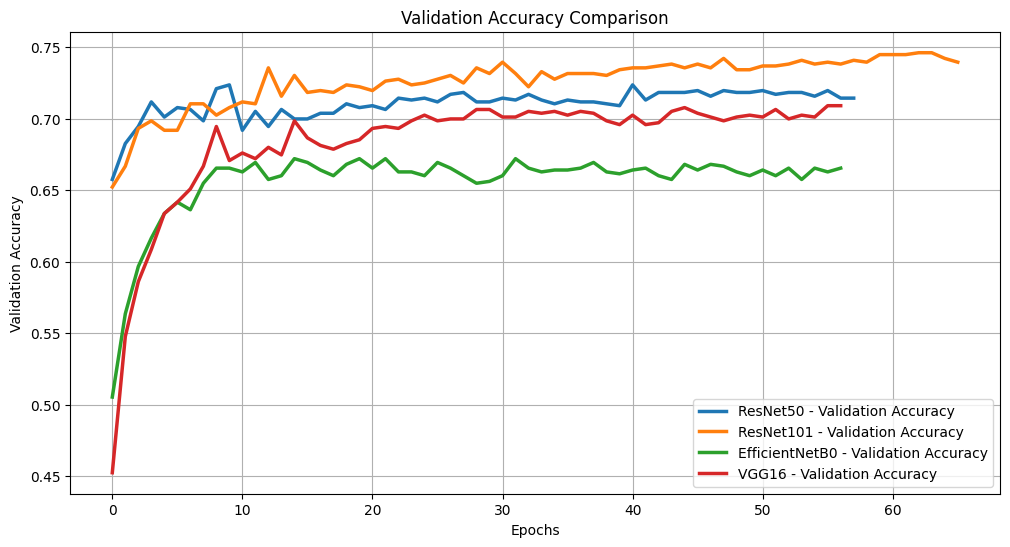

In [64]:
models = ["ResNet50", "ResNet101", "EfficientNetB0", "VGG16"]
histories = [history_resnet50, history_resnet101, history_efficientnet, history_vgg16]

plt.figure(figsize=(12, 6))
for model_name, history in zip(models, histories):
    plt.plot(history.history['val_accuracy'], label=f'{model_name} - Validation Accuracy', linewidth=2.5)

plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Overall Comparison**

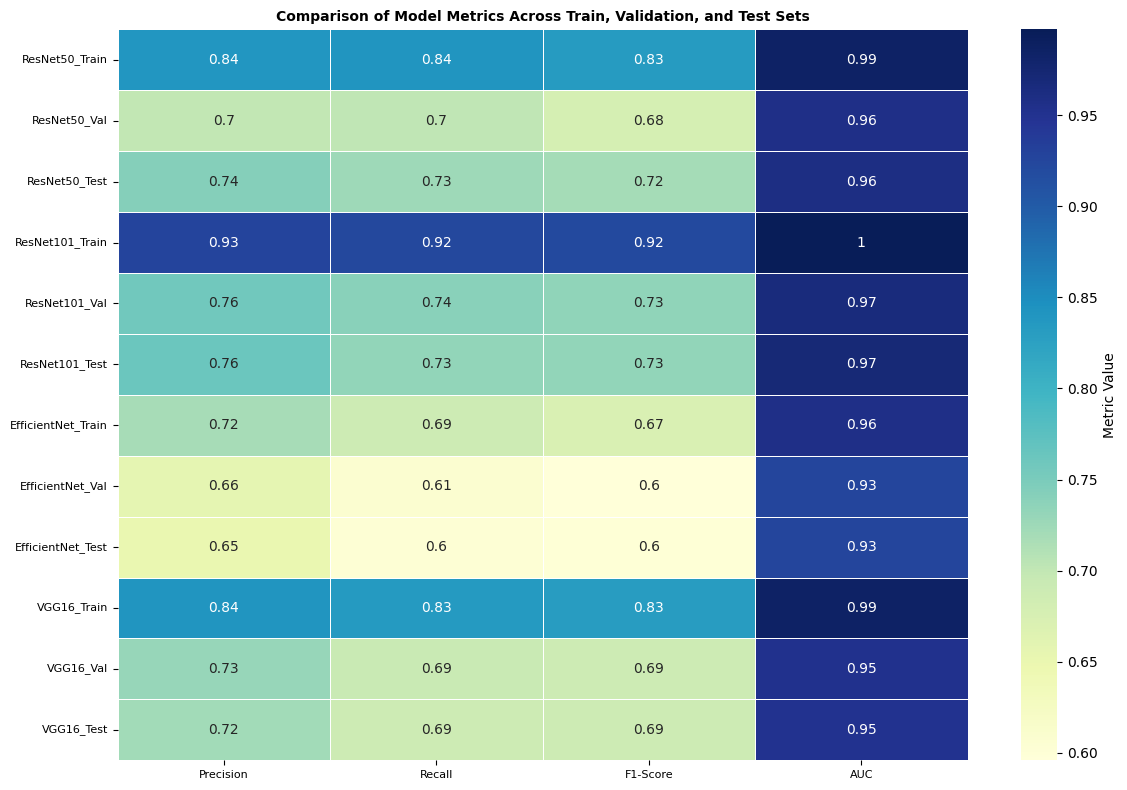

In [56]:
metrics_data = {
    'Precision': [0.8392, 0.7006, 0.7419, 0.9273, 0.7579, 0.7627, 0.7184, 0.6581, 0.6499, 0.8418, 0.7302, 0.7217],
    'Recall': [0.8412, 0.7017, 0.7253, 0.9231, 0.7396, 0.7328, 0.6888, 0.6072, 0.6024, 0.8343, 0.6933, 0.6893],
    'F1-Score': [0.8335, 0.6786, 0.7207, 0.9217, 0.7341, 0.7330, 0.6736, 0.5960, 0.6001, 0.8314, 0.6888, 0.6892],
    'AUC': [0.9856, 0.9565, 0.9600, 0.9970, 0.9663, 0.9717, 0.9564, 0.9264, 0.9264, 0.9855, 0.9529, 0.9514]
}

models_sets = [
    "ResNet50_Train", "ResNet50_Val", "ResNet50_Test",
    "ResNet101_Train", "ResNet101_Val", "ResNet101_Test",
    "EfficientNet_Train", "EfficientNet_Val", "EfficientNet_Test",
    "VGG16_Train", "VGG16_Val", "VGG16_Test"
]

metrics_df = pd.DataFrame(metrics_data, index=models_sets)

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Metric Value'}, linewidths=0.5)
plt.title("Comparison of Model Metrics Across Train, Validation, and Test Sets", fontsize=10, fontweight='bold')
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Model Performance Analysis

---

## ResNet50 Metrics Analysis:
- **Training Set:**
  - Accuracy: 83.4%
  - Precision, Recall, and F1-Score are generally high, but certain classes, such as “5-Miscellaneous Trash”, show lower performance (precision = 88.6%, recall = 56.1%).
  - Classes like “2-Food Organics” (Precision = 86.5%, Recall = 97.7%) and “9-Vegetation” (Precision = 85.3%, Recall = 97.8%) perform exceptionally well.
  - This indicates that the model effectively learns certain classes while struggling with others, especially the “Miscellaneous Trash”.

- **Validation Set:**
  - Accuracy drops to 71.16%.
  - Significant performance degradation for some classes, such as “3-Glass” (Precision = 86.2%, Recall = 37.3%) and “5-Miscellaneous Trash” (Precision = 33.3%, Recall = 12.7%).
  - This suggests possible overfitting on the training set, where the model memorizes training examples but struggles with unseen data.

- **Test Set:**
  - Accuracy: 74.11%
  - The model shows better performance on the test set than on the validation set, but some classes still struggle (e.g., “3-Glass” with 49% recall and “5-Miscellaneous Trash” with 29% recall).
  - The “2-Food Organics” class maintains strong performance.

---

## ResNet101 Metrics Analysis:
- **Training Set:**
  - Accuracy: 92.1% (Significantly higher than ResNet50).
  - Precision, Recall, and F1-Score are high across most classes.
  - Classes such as “3-Glass” (93.8%) and “9-Vegetation” (94.4%) exhibit strong performance.
  - This indicates that ResNet101 learns better representations of the data due to its increased model depth.

- **Validation Set:**
  - Accuracy: 74.47% (Better than ResNet50’s 71.16%).
  - Notable improvements in “3-Glass” (93.2% Precision), but a drop in “5-Miscellaneous Trash” (41.9%).
  - The model generalizes better than ResNet50 but still struggles with certain classes.

- **Test Set:**
  - Accuracy: 75.26% (Best among all models so far).
  - Strong performance for “2-Food Organics” (83.7%) and “9-Vegetation” (84.9%).
  - The model maintains consistent performance across all sets.

---

## EfficientNetB0 Metrics Analysis:
- **Training Set:**
  - Accuracy: 68.57% (Lowest among all models).
  - The model struggles significantly with “3-Glass” (Precision = 81.3%, Recall = 24.2%) and “6-Paper” (Precision = 82.7%, Recall = 52.2%).
  - This indicates underfitting, where the model fails to learn the complex representations needed for the task.

- **Validation Set:**
  - Accuracy: 61.38% (Lowest validation accuracy).
  - Massive performance drop for classes like “3-Glass” (94.7% Precision, 26.9% Recall).
  - The model fails to generalize well.

- **Test Set:**
  - Accuracy: 62.16% (Also the lowest).
  - Similar issues with “3-Glass” and “5-Miscellaneous Trash”.
  - This model struggles to effectively classify several classes, indicating a significant underfitting problem.

---

## VGG16 Metrics Analysis:
- **Training Set:**
  - Accuracy: 83.14% (Comparable to ResNet50).
  - The model performs well across most classes, with some issues in “5-Miscellaneous Trash” (75.5%) and “2-Food Organics” (83.8%).
  - Notably, “9-Vegetation” has a very high precision of 98.2%.

- **Validation Set:**
  - Accuracy: 70.63% (Slightly lower than ResNet50 and ResNet101).
  - Consistent performance but some weaknesses in “3-Glass” (54.2%) and “5-Miscellaneous Trash” (38.5%).
  - The model maintains relatively balanced performance without extreme highs or lows.

- **Test Set:**
  - Accuracy: 70.34% (Slightly lower than ResNet101 and ResNet50).
  - The model shows a balanced performance across most classes but struggles with “3-Glass” (49.6%).
  - Performance is relatively stable but not exceptional.

---

## **Which Model Clearly Outperforms the Others?**
- ResNet101 is the best performing model overall.
  - It has the highest training accuracy (92.1%), validation accuracy (74.47%), and test accuracy (75.26%).
  - The model shows consistent performance across all sets without extreme fluctuations in class performance.
  - It effectively generalizes to unseen data, avoiding overfitting issues seen in ResNet50.
  - ResNet101 benefits from its deeper architecture, allowing it to learn more complex features.

- EfficientNetB0 performs the worst.
  - It has the lowest accuracy on all sets (Training: 68.57%, Validation: 61.38%, Test: 62.16%).
  - The model fails to learn complex class representations, especially for “3-Glass” and “5-Miscellaneous Trash”.
  - This indicates underfitting, where the model is too simplistic for the problem.

- ResNet50 is moderately good.
  - It has consistent performance but fails to match the depth and representation capabilities of ResNet101.
  - It struggles with “5-Miscellaneous Trash” on all sets.

- VGG16 is generally stable.
  - It maintains good accuracy but does not reach the performance of ResNet101.
  - The model struggles with “3-Glass” and “5-Miscellaneous Trash” but performs well in other classes.

# **References**

- https://docs.python.org/3/library/shutil.html
- https://docs.python.org/3/library/json.html
- https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
- https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
- https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet101.html
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0
- https://keras.io/api/applications/vgg/
- https://www.tensorflow.org/api_docs/python/tf/keras/layers
- https://www.tensorflow.org/api_docs/python/tf/keras/Model
- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
- https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
- https://stackoverflow.com/questions/63423463/using-pytorch-cuda-on-macbook-pro

# **ChatGPT Help**

**Que: What does ImageDataGenerator do?**

**Ans:**

`ImageDataGenerator` in TensorFlow/Keras is a class that allows you to perform real-time data augmentation on image data. It is commonly used to:
- Perform data augmentation (rotation, zooming, flipping) to prevent overfitting.
- Normalize pixel values of images.
- Efficiently generate augmented image batches for training, validation, and testing.

Basic Syntax:
```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an ImageDataGenerator object with augmentation options
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalizing pixel values (0-1)
    rotation_range=20,            # Randomly rotate images (in degrees)
    width_shift_range=0.2,        # Randomly shift images horizontally
    height_shift_range=0.2,       # Randomly shift images vertically
    zoom_range=0.2,               # Randomly zoom images
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode='nearest'           # Fill mode for pixels outside image boundaries
)

# Generating augmented images from a directory
train_generator = train_datagen.flow_from_directory(
    'path/to/train_data',        # Path to training data
    target_size=(224, 224),      # Resizing images to (224, 224)
    batch_size=32,               # Number of images per batch
    class_mode='categorical'     # For multi-class classification
)
```
---

**Que: Is it better to use sequential or directly building the model step by step?**

**Ans:**

The choice between using Sequential API and Functional API (Step-by-Step) in Keras depends on the complexity of your model and your specific requirements:

Sequential API: When to Use?
- Best for Simple Models: Only suitable for models with a single input and a single output.
- Linear Stack: Layers are added one after the other in a straight line.
- Easier to Read: Simple syntax makes it beginner-friendly.

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten

# Sequential Model Definition
model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
```

Functional API (Step-by-Step): When to Use?
- Best for Complex Models: Supports multiple inputs, outputs, shared layers, and even non-linear architectures.
- Greater Flexibility: Allows any form of network architecture.
- Easier to Customize: Custom blocks, skip connections, and parameter sharing are possible.

```python
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Input Layer
input_layer = Input(shape=(784,))
x = Dense(128, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)

# Defining the Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
```